# Tracks Genre Classification

- What does each playlist set sound like? What are their defining characteristics?

- Using user-marked playlist genres as training data, can we build a model to correctly classify songs from a separate track dataset?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read the training data

In [8]:
pdf = pd.read_csv('https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/Rock_playlist_tracks_data.csv')

In [11]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["Rock", "Hiphoprapcons", "Country", "Jazz", "Classical", "Electronic", "Folk"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    try:
        pdf = pd.read_csv('https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/'+genre.lower()+'_playlist_data.csv')
        pdf['genre'] = genre.lower().replace('&','n')
        playlist_df_list.append(pdf)
    except:
        pdf = pd.read_csv('https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/'+genre+'_playlist_data.csv')
        pdf['genre'] = genre.lower().replace('&','n')
        playlist_df_list.append(pdf)
    try:
        tdf = pd.read_csv('https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/'+genre+'_playlist_tracks_data.csv')
        tdf['genre'] = genre.lower().replace('&','n')
        track_df_list.append(tdf)
    except:
        tdf = pd.read_csv('https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/'+genre.lower()+'_playlist_tracks_data.csv')
        tdf['genre'] = genre.lower().replace('&','n')
        track_df_list.append(tdf)
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


In [12]:
#check shape
playlist_df.shape, tracks_df.shape

((734, 7), (7000, 22))

In [4]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'playlist_name' 'genre']


In [5]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [6]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(7000, 22)

In [7]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

6811

In [8]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(6811, 22)

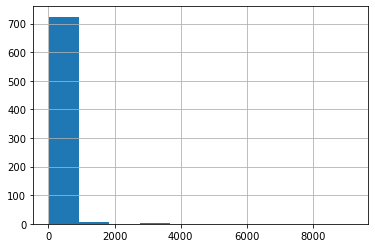

In [9]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

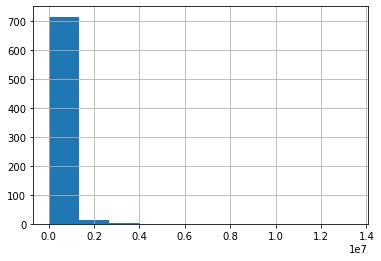

In [10]:
# What is the distribution of playlist's total followers?
playlist_df['total_followers'].hist()

In [11]:
tracks_df['genre'].value_counts()

country          1000
hiphoprapcons    1000
folk              997
jazz              985
classical         958
electronic        946
rock              925
Name: genre, dtype: int64

In [12]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

country          0.146821
hiphoprapcons    0.146821
folk             0.146381
jazz             0.144619
classical        0.140655
electronic       0.138893
rock             0.135810
Name: genre, dtype: float64

## 2. Refine the training data

In [215]:
#get top playlists
#top_playlists_df = playlist_df.groupby('genre').head(5)
#top_playlists_df.head()

In [216]:
#tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
#tracks_df['genre'].value_counts()

## 3. Feature Engineering

##### Conversions/Normalizations

In [13]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [14]:
#Normalize loudness
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    6811.000000
mean        0.780758
std         0.140160
min         0.000000
25%         0.718398
50%         0.821987
75%         0.881778
max         1.000000
Name: loudness, dtype: float64

In [15]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    6811.000000
mean        0.549836
std         0.143414
min         0.000000
25%         0.434607
50%         0.546267
75%         0.651976
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [16]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
playlist_name         object
genre               category
duration_mins        float64
dtype: object

In [17]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,duration_mins,genre_id
0,70YvYr2hGlS01bKRIho1HM,La Grange - 2005 Remaster,2AM4ilv6UzW0uMRuqKtDgN,ZZ Top,0Em8m9kRctyH9S3MTXAHvY,230480,1973-07-26,75,0.545,0.640,...,0.00249,0.030400,0.1960,0.606,0.381254,37i9dQZF1DWWwzidNQX6jx,70s Rock Anthems,rock,3.841333,6
1,1oG2vWELiGjIqxwqGcyqwF,You Really Got Me,1SQRv42e4PjEYfPhS0Tk9E,The Kinks,3hXXoaAA09avxBSSxtPIaL,133933,1964-10-02,0,0.567,0.959,...,0.09950,0.000061,0.1000,0.961,0.650271,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2.232217,6
2,3fkPMWQ6cBNBLuFcPyMS8s,Burnin' for You,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,7v4kEpVtppoMm80m43lGzt,271000,1981-10-23,67,0.532,0.728,...,0.10600,0.010800,0.0849,0.690,0.635721,3Ho3iO0iJykgEQNbjB2sic,"Classic Rock 70s 80s 90s, Rock Classics - 70s ...",rock,4.516667,6
3,1DKAjHZD5QDq9tAwiZhhCX,Bound,37EbZutVi8JaIn1lhFBx45,Ocean Hills,4T4gIMdh94mwbbOaC85qSC,178973,2020-09-25,38,0.409,0.842,...,0.00001,0.039300,0.1820,0.576,0.880091,37i9dQZF1DWWJOmJ7nRx0C,Rock Hard,rock,2.982883,6
4,1dJuteDIOkGfDSN7zPkzNv,She Don't Use Jelly,16eRpMNXSQ15wuJoeqguaB,The Flaming Lips,0rr668ZzoNDQa1yxhSpBAw,222278,1993-06-18,61,0.330,0.556,...,0.20700,0.000044,0.3150,0.506,0.822812,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,rock,3.704633,6


In [18]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{6: 'rock',
 4: 'hiphoprapcons',
 1: 'country',
 5: 'jazz',
 0: 'classical',
 2: 'electronic',
 3: 'folk'}

## 4. Train a KNN model

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report

In [224]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(5448, 9)
Shape of y_Train:(5448,)
Shape of X_Test:(1363, 9)
Shape of y_Test:(1363,)
Finding best k...


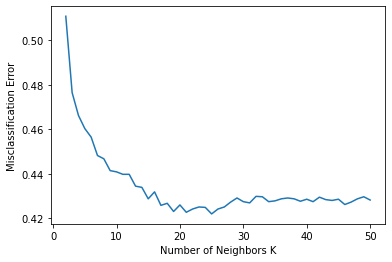

The optimal number of neighbors is 25 with score 57%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(5448, 9)
Shape of y_Train:(5448,)
Shape of X_Test:(1363, 9)
Shape of y_Test:(1363,)
Finding best k...


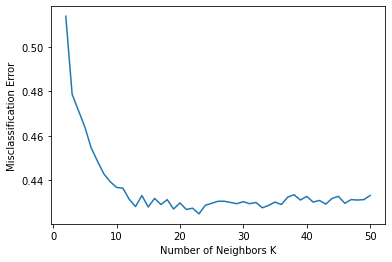

The optimal number of neighbors is 23 with score 57%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(5448, 9)
Shape of y_Train:(5448,)
Shape of X_Test:(1363, 9)
Shape of y_Test:(1363,)
Finding best k...


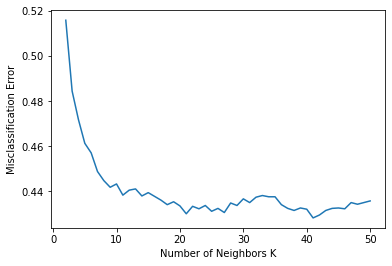

The optimal number of neighbors is 41 with score 57%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(5448, 9)
Shape of y_Train:(5448,)
Shape of X_Test:(1363, 9)
Shape of y_Test:(1363,)
Finding best k...


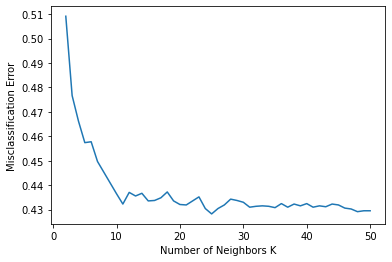

The optimal number of neighbors is 25 with score 57%


In [20]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [21]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[25, 23, 41, 25]

## 5. Model Prediction

In [25]:
chart_tracks_df = pd.read_csv("https://raw.githubusercontent.com/knocom/Sprint3_SpotifyRecommenderEngine/main/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6IdEQ3HUseBeRUYFSzSMdL,Zebbiana,117XFtbZPnCI1EYKjYZWJc,Skusta Clee,4AaygWd1ZnCzZ4ak9EM23s,304664,2019-07-26,64,0.677,0.433,8,-8.518,1,0.0370,0.5450,0.000000,0.1050,0.498,134.006
1,6v3KW9xbzN5yKLt9YKDYA2,Señorita,7n2wHs1TKAczGzO7Dd2rGr,Shawn Mendes,0xzScN8P3hQAz3BT3YYX5w,190799,2019-06-19,82,0.759,0.548,9,-6.049,0,0.0290,0.0392,0.000000,0.0828,0.749,116.967
2,1dGr1c8CrMLDpV6mPbImSI,Lover,06HL4z0CvFAxyc27GXpf02,Taylor Swift,1NAmidJlEaVgA3MpcPFYGq,221306,2019-08-23,79,0.359,0.543,7,-7.582,1,0.0919,0.4920,0.000016,0.1180,0.453,68.534
3,0gDRtumoR9ZrvAlnniToMz,Ikaw At Ako,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,397zfeJ75BlnjfUEkgtwlG,269876,2019-01-14,64,0.445,0.355,4,-7.351,1,0.0289,0.8870,0.001790,0.3220,0.366,135.525
4,5l9g7py8RCblcvbZgGQgSd,Pagtingin,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,7xCcuTA3abKwxj8HwgxP7R,227370,2019-05-12,68,0.669,0.420,2,-8.464,1,0.0253,0.5060,0.000000,0.4040,0.523,95.049


In [26]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [29]:
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=1 #pick kfold=5
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 23


In [30]:
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,all_genre_prob
0,6IdEQ3HUseBeRUYFSzSMdL,Zebbiana,117XFtbZPnCI1EYKjYZWJc,Skusta Clee,4AaygWd1ZnCzZ4ak9EM23s,304664,2019-07-26,64,0.677,0.433,...,0.0370,0.54500,0.000000,0.1050,0.498,0.525706,1,country,0.347826,"[0.0, 0.34782608695652173, 0.0, 0.304347826086..."
1,6v3KW9xbzN5yKLt9YKDYA2,Señorita,7n2wHs1TKAczGzO7Dd2rGr,Shawn Mendes,0xzScN8P3hQAz3BT3YYX5w,190799,2019-06-19,82,0.759,0.548,...,0.0290,0.03920,0.000000,0.0828,0.749,0.415709,4,hiphoprapcons,0.391304,"[0.0, 0.17391304347826086, 0.0, 0.086956521739..."
2,1dGr1c8CrMLDpV6mPbImSI,Lover,06HL4z0CvFAxyc27GXpf02,Taylor Swift,1NAmidJlEaVgA3MpcPFYGq,221306,2019-08-23,79,0.359,0.543,...,0.0919,0.49200,0.000016,0.1180,0.453,0.103044,3,folk,0.391304,"[0.0, 0.30434782608695654, 0.0, 0.391304347826..."
3,0gDRtumoR9ZrvAlnniToMz,Ikaw At Ako,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,397zfeJ75BlnjfUEkgtwlG,269876,2019-01-14,64,0.445,0.355,...,0.0289,0.88700,0.001790,0.3220,0.366,0.535512,3,folk,0.434783,"[0.17391304347826086, 0.2608695652173913, 0.0,..."
4,5l9g7py8RCblcvbZgGQgSd,Pagtingin,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,7xCcuTA3abKwxj8HwgxP7R,227370,2019-05-12,68,0.669,0.420,...,0.0253,0.50600,0.000000,0.4040,0.523,0.274215,1,country,0.391304,"[0.0, 0.391304347826087, 0.0, 0.26086956521739..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,0zzVTGyRrWpQu8Fr28NRAv,OK Not To Be OK,64KEffDW9EtZ1y2vBYgq8T,Marshmello,3wCtCJ8O6SlGBWYfzAlsb2,159862,2020-09-10,85,0.743,0.837,...,0.0649,0.01720,0.000000,0.0743,0.263,0.326008,4,hiphoprapcons,0.565217,"[0.0, 0.30434782608695654, 0.04347826086956521..."
1057,4G7uzhxgKFBCJApBpuuBgU,Kabet,3ID2V4b0oGSEbwPENAsdbG,Gagong Rapper,0bFldkQiVA9IiOch2GHQGq,318040,2020-09-07,59,0.721,0.742,...,0.0377,0.67000,0.000001,0.1210,0.308,0.177013,3,folk,0.347826,"[0.0, 0.30434782608695654, 0.04347826086956521..."
1058,3KUGAgxo3b81X5bWoOp0U8,Back Door,2dIgFjalVxs4ThymZ67YCE,Stray Kids,0Kp2UZGWRQHa3B5e8t93rI,189286,2020-09-14,56,0.820,0.842,...,0.2720,0.15700,0.000000,0.1120,0.653,0.357512,4,hiphoprapcons,0.956522,"[0.0, 0.0, 0.0, 0.0, 0.9565217391304348, 0.043..."
1059,0rbKrBvZUYY9GN9l057BuY,"always, i'll care",3gIRvgZssIb9aiirIg0nI3,Jeremy Zucker,5mkf4N44kdEwYgaOk3hRLF,146160,2020-04-17,71,0.732,0.221,...,0.0560,0.89700,0.000026,0.1100,0.677,0.339520,3,folk,0.565217,"[0.08695652173913043, 0.21739130434782608, 0.0..."


In [31]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk_prob,predicted_hiphoprapcons_prob,predicted_jazz_prob,predicted_rock_prob
664,55CHeLEfn5iJ0IIkgaa4si,Savage,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,6Lo6ylJg4qbFfxicPEOzMI,155497,2020-03-06,82,0.843,0.741,...,4,hiphoprapcons,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0
459,7k4t7uLgtOxPwTpFmtJNTY,Tusa,790FomKkXshlbRYZFtlgla,KAROL G,7mKevNHhVnZER3BLgI8O4F,200960,2019-11-07,88,0.803,0.715,...,4,hiphoprapcons,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0
581,6KUE0HSSudAp9AOycaF6SH,Make It Right,3Nrfpe0tUJi4K4DXYWgMUX,BTS,1AvXa8xFEXtR3hb4bgihIK,226321,2019-04-12,72,0.638,0.703,...,4,hiphoprapcons,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0
921,6EDO9iiTtwNv6waLwa1UUq,POPSTAR (feat. Drake),0QHgL1lAIqAw0HtD7YldmP,DJ Khaled,5nNtpPsSUgb9Hlb3dF1gXa,200221,2020-07-17,93,0.800,0.560,...,4,hiphoprapcons,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0
138,6EOKwHETwSkZ9gW2b6ASE0,Ransom,4Ga1P7PMIsmqEZqhYZQgDo,Lil Tecca,65T18oWoikW2MAilg9j8lW,131240,2019-08-30,3,0.745,0.642,...,4,hiphoprapcons,0.956522,0.0,0.0,0.043478,0.0,0.956522,0.0,0.0


Check out tracks with highest assigned probability

In [32]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
664,Megan Thee Stallion,Savage,hiphoprapcons,1.000000
459,KAROL G,Tusa,hiphoprapcons,1.000000
581,BTS,Make It Right,hiphoprapcons,1.000000
921,DJ Khaled,POPSTAR (feat. Drake),hiphoprapcons,1.000000
138,Lil Tecca,Ransom,hiphoprapcons,0.956522
777,Agust D,Daechwita,electronic,0.913043
445,Gary Valenciano,Pasko Na Sinta Ko,classical,0.913043
709,The Juans,Hatid,classical,0.869565
718,Gaho,시작,country,0.782609
1037,Jose Mari Chan,It Is the Lord!,classical,0.782609


View histogram of predicted genre probabilities

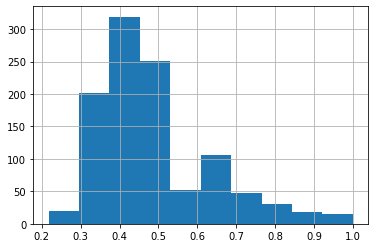

In [33]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [34]:
chart_tracks_df['predicted_genre'].value_counts()

country          357
hiphoprapcons    257
folk             234
rock             114
electronic        52
jazz              28
classical         19
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [35]:
chart_tracks_df[chart_tracks_df['track_name']=='Kathang Isip']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk_prob,predicted_hiphoprapcons_prob,predicted_jazz_prob,predicted_rock_prob
21,3WUEs51GpcvlgU7lehLgLh,Kathang Isip,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,4nQxblVnnFPehg9ujzdJ8L,318814,2017-06-23,71,0.491,0.314,...,3,folk,0.521739,0.086957,0.217391,0.0,0.521739,0.0,0.086957,0.086957


In [36]:
chart_tracks_df[chart_tracks_df['track_name']=='Pagtingin']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk_prob,predicted_hiphoprapcons_prob,predicted_jazz_prob,predicted_rock_prob
4,5l9g7py8RCblcvbZgGQgSd,Pagtingin,4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,7xCcuTA3abKwxj8HwgxP7R,227370,2019-05-12,68,0.669,0.42,...,1,country,0.391304,0.0,0.391304,0.0,0.26087,0.043478,0.086957,0.217391


In [37]:
chart_tracks_df[chart_tracks_df['track_name']=='Dynamite']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk_prob,predicted_hiphoprapcons_prob,predicted_jazz_prob,predicted_rock_prob
1030,0t1kP63rueHleOhQkYSXFY,Dynamite,3Nrfpe0tUJi4K4DXYWgMUX,BTS,6K4chJALBBMYmXjwgvqahx,199053,2020-08-28,97,0.746,0.765,...,1,country,0.304348,0.0,0.304348,0.0,0.0,0.304348,0.086957,0.304348
1007,0v1x6rN6JHRapa03JElljE,Dynamite,3Nrfpe0tUJi4K4DXYWgMUX,BTS,3zWmE5c3alhuoPLphxjMVd,199053,2020-08-21,83,0.746,0.765,...,1,country,0.304348,0.0,0.304348,0.0,0.0,0.304348,0.086957,0.304348


In [38]:
#save data
chart_tracks_df.to_csv("C:/Users/knocom/Eskwelabs Jupyter Notebooks/Sprint 3/get_spotify_data-master/data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Caveats
1. Using playlist names as genre tags heavily rely on *user opinion* and not *extracted music features* (compare this from the methods used in the [GTZAN genre collection dataset](https://data-flair.training/blogs/python-project-music-genre-classification/)
2. Playlists with dual genre names exists, and appear quite often in the dataset (e.g. Electronic Pop, Classical Rock)
3. Although a dominant genre could be readily observed, recent music tend to incorporate many genres at a time and thus create less distinction when the model looks at the audio features.

>Q: What other caveats could you deduce from the steps done above?


## Model Improvement
To enhance the model accuracy, try to do the following:
1. Pick "purer" top-followed playlists for the training data. A quick way to do this is to pick playlists that contain pre 2000's music as majority as these are less hybridized than more recent songs.
2. Try fewer but broader genres as categories (4-5 genres)
3. Remove outlier songs! These are the songs that dont fit its playlist's description. A bit subjective (and tedious!).
4. Limit the features used as predictors (could be inferred from the list of genres you're considering)


## Day Deliverable
*A. For your individual curiosities*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. For your sprint project*
4. Extract a tracks dataset that is relevant to the client you are targeting. 
   For example:
    - A client artist's full discography
    - Tracks from a popular playlist in spotify that your client artist appears in
    - Discographies of prospect artists to collaborate with 
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   

